In [299]:
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
import pyrtools as pt
from tqdm import tqdm 
import pickle

In [333]:
image_path1 = 'data/Fur.jpg'
image_path2 = 'data/Red.jpg'

In [334]:
image1 = preprocess_image(image_path1, new_size = (75,75))
image2 = preprocess_image(image_path2, new_size = (75,75))
textures = [image1, image2]

In [390]:
def compute_sliced_wass_barycenter(distributions, rho = None, lr = 1e3, k = 200, nb_iter_max = 50, xbinit = None):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    distributions = [x.astype(np.float64) for x in distributions]
    x_torch = [torch.tensor(x).to(device=device) for x in distributions]
    print(distributions[0].dtype)

    if rho is None: 
        n = len(distributions)
        rho = n*[1/n]
    
    if xbinit is None:
        #xbinit = np.random.randn(500, 2) * 10 + 16 #initialization
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)
    print(xbinit.dtype)


    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))

    loss_iter = []

    # generator for random permutations
    gen = torch.Generator(device=device)
    gen.manual_seed(42)


    for i in range(nb_iter_max):

        loss = 0
        for i, x in enumerate(x_torch):
            loss += rho[i] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=50, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()

    xb = xbary_torch.clone().detach().cpu().numpy()
    return(xb)

In [335]:
def compute_steerable_pyramid_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute steerable pyramid coefficients with specified orientations using pyrtools.
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - coeffs: Dictionary of coefficients organized by scale and orientation.
    """
    # Initialize the steerable pyramid
    pyramid = pt.pyramids.SteerablePyramidFreq(image, height=num_scales, order=num_orientations-1)

    return pyramid.pyr_coeffs, pyramid

In [336]:
coef, pyr = compute_steerable_pyramid_coeffs(image1[:,:,1], num_scales=4, num_orientations=4)


In [337]:
def compute_3D_wavelets_coeffs(image, num_scales=4, num_orientations=4):
    """
    Compute wavelets coefficients (highpass, bandpass, low-residuals) for the 3 channels (R,G,B) of an image
    
    Parameters:
    - image: 2D numpy array, input grayscale image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - wavelets_coeffs: Dictionary of coefficients organized by channel (R,G,B) and then by bandpass (highpass, bandpass -scale and orientation- and low residual).
    """
    wavelets_coeffs = {}
    rgb = ['R','G','B']
    for channel in range(3):
        wavelets_coeffs[rgb[channel]], _ = compute_steerable_pyramid_coeffs(image[:, :, channel], num_scales=num_scales, num_orientations=num_orientations)
    return(wavelets_coeffs)

In [338]:
def compute_wavelet_coeffs_barycenter(textures, num_scales=4, num_orientations=4):
    """
    Compute the barycenter of wavelets coefficients --> Y^l (see page 9 in paper)
    
    Parameters:
    - textures: 3D numpy array, input RGB image.
    - num_scales: int, number of scales.
    - num_orientations: int, number of orientations.

    Returns:
    - bar_wavelet_coeffs_RGB: Dictionary of barycenters of wavelets coefficients by channel (R,G,B) and then by highpass/bandpass/lowresidual
    """

    bar_wavelet_coeffs = {}
    bar_wavelet_coeffs_RGB = {}
    RGB = ['R','G','B']
    wavelets_coeffs = [compute_3D_wavelets_coeffs(image) for image in textures]

    for rgb in RGB:
        for k in wavelets_coeffs[0][rgb].keys():
                distributions = [w[rgb][k].reshape(-1,1) for w in wavelets_coeffs] #reshape --> flattens the image to compute the barycenter
                n = int(np.sqrt(distributions[0].shape[0]))
                bar_wavelet_coeffs[k] = (compute_sliced_wass_barycenter(distributions, rho = None)).reshape(n, n)
        bar_wavelet_coeffs_RGB[rgb] = bar_wavelet_coeffs
    return(bar_wavelet_coeffs_RGB)

In [339]:
#Y_l = compute_wavelet_coeffs_barycenter(textures, num_scales=4, num_orientations=4)

In [340]:
with open('Yl.pkl', 'rb') as file:
        # Loading the data from the pickle file
        Y_l = pickle.load(file)

In [341]:
def initialize_random_image(size=(256, 256), channels=3):
    """Initialize a random white noise image f^(0)."""
    return np.random.rand(*size, channels)

In [342]:
def projection(X0, Y):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200,  nb_iter_max = 50, xbinit = X0)
    return(proj)

In [343]:
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [344]:
def from_dict_to_RGB_array(dico):

    output_dict = {}

    # Extract unique filter types by parsing keys
    filters = set(key.split('.')[1] for key in dico.keys())

    # Iterate through each unique filter
    for filter_type in filters:
        # Collect the R, G, B arrays for the current filter
        r_key = f'R.{filter_type}'
        g_key = f'G.{filter_type}'
        b_key = f'B.{filter_type}'
        
        if r_key in dico and g_key in dico and b_key in dico:
            # Stack R, G, B arrays along a new third axis to form a (P, Q, 3) array
            rgb_array = np.stack([dico[r_key], dico[g_key], dico[b_key]], axis=-1)
            
            # Add to output dictionary
            output_dict[filter_type] = rgb_array
    return(output_dict)


In [345]:
f_0 = initialize_random_image(size=(75, 75), channels=3)
f_0_pyr = compute_3D_wavelets_coeffs(f_0, num_scales=4, num_orientations=4)
f_0_pyr = flatten_dict(f_0_pyr)
f_0_pyr = from_dict_to_RGB_array(f_0_pyr)
Y_l = from_dict_to_RGB_array(Y_l)

In [346]:
c_l_n = {}
for key in Y_l.keys():
    Y_l_filter = Y_l[key].reshape(-1,3)
    f_0_filter = f_0_pyr[key].reshape(-1,3)
    c_l_n[key] = projection(f_0_filter, Y_l_filter)

In [351]:
import ast

def from_str_to_tuple_dict(data_dict):

    # New dictionary to hold the modified keys
    modified_dict = {}

    # Iterate over the original dictionary
    for key, value in data_dict.items():
        # Try to convert keys that look like tuples into actual tuple types
        try:
            # Use ast.literal_eval to safely evaluate keys that are tuples as strings
            evaluated_key = ast.literal_eval(key)
            if isinstance(evaluated_key, tuple):
                modified_dict[evaluated_key] = value
            else:
                modified_dict[key] = value
        except (ValueError, SyntaxError):
            # If the key isn't a tuple-like string, keep it as-is
            modified_dict[key] = value
    return(modified_dict)

In [352]:
c_l_n = from_str_to_tuple_dict(c_l_n)

In [353]:
dict_r = {}
dict_g = {}
dict_b = {}

for key in c_l_n.keys():
    size = int(np.sqrt(c_l_n[key].shape[0]))
    dict_r[key] = c_l_n[key][:,0].reshape(size, size)
    dict_g[key] = c_l_n[key][:,1].reshape(size, size)
    dict_b[key] = c_l_n[key][:,2].reshape(size, size)


In [354]:
pyr.pyr_coeffs = dict_r
f_k_r = pyr.recon_pyr()
pyr.pyr_coeffs = dict_g
f_k_g = pyr.recon_pyr()
pyr.pyr_coeffs = dict_b
f_k_b = pyr.recon_pyr()

In [396]:
f_k = np.stack((f_k_r, f_k_g, f_k_b), axis=-1)

In [392]:
Y_r = compute_sliced_wass_barycenter([x[:,:,0] for x in textures])
Y_g = compute_sliced_wass_barycenter([x[:,:,1] for x in textures])
Y_b = compute_sliced_wass_barycenter([x[:,:,2] for x in textures])
Y = np.stack((Y_r, Y_g, Y_b), axis=-1)

float64
float64
float64
float64
float64
float64


In [ ]:
f_k_1 = projection(f_k.reshape(-1,3), Y.reshape(-1,3)).reshape((75,75,3))

float64
float64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


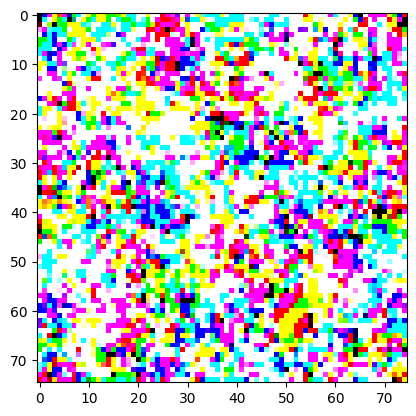

In [400]:
plt.imshow(f_k_1.reshape((75,75,3)))

In [ ]:
# Saving to a Pickle file
# with open('c_l_n.pkl', 'wb') as file:
#     pickle.dump(flatten_dict(c_l_n), file)